This notebook can be used to hyperparameter tune the early stopping criteria (rather than specifying them):
* Maximum number of iterations before stopping (still capped at 10, the default maximum)
* The early stop delta, i.e., if the success probability changes by less than this number across 3 iterations, stop early
* The early stop confidence threshold, i.e., how confident VLM should be to stop early

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

In [2]:
import argparse
from collections import defaultdict, Counter
from copy import deepcopy
from itertools import product
import json
import numpy as np
import os
import pickle
from PIL import Image
from pprint import pprint
import spacy
import time
import torch
from tqdm import tqdm
from transformers import AutoModelForVision2Seq, AutoModelForCausalLM, AutoProcessor, BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer, PhrasalConstraint           

from travel.constants import RESULTS_DIR, IMAGES_CHUNK_SIZE, HF_TOKEN
from travel.data.captaincook4d import CaptainCook4DDataset
from travel.data.ego4d import Ego4DMistakeDetectionDataset
from travel.data.mistake_detection import MistakeDetectionTasks
from travel.data.vqa import VQAResponse, get_vqa_response_token_ids, VQAOutputs, DIALOG_START_TOKENS, IMAGE_TOKENS, USER_START_TOKENS, USER_END_TOKENS, ASSISTANT_START_TOKENS, ASSISTANT_END_TOKENS, IVQA_PREAMBLE, IVQA_SUCCESS_QUESTION
from travel.data.vqg import generate_vqg_prompt_icl
from travel.model import simple_lm_prompt_beam_search, simple_vlm_prompt_beam_search, compute_completion_log_likelihoods, compute_completion_log_likelihoods_encoder_decoder, compute_completion_log_likelihoods_vlm
from travel.model.grounding import VisualFilterTypes, ContrastiveRegionFilter, VisualContrastiveFilter, SpatialVisualFilter, AGLAFilter, ImageMaskTypes
from travel.model.metrics import mistake_detection_metrics, question_coherence_metrics_nli, question_coherence_metrics_vlm, generate_det_curve, generate_tiered_metric_curves, entropy, compile_accuracy_and_coherence_metrics
from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS
from travel.model.nli import NLI_MODEL_PATH, NLI_BATCH_SIZE
from travel.model.vqa import run_vqa_with_visual_filter
from travel.model.vqg import cleanup_generated_question


In [3]:
VLM_NAME = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

# Load VLM - some VLMs may be under AutoModelForVision2Seq, some may be under AutoModelForCausalLM
try:
    vlm = AutoModelForVision2Seq.from_pretrained(VLM_NAME, quantization_config=bnb_config, trust_remote_code=True, token=HF_TOKEN)   
except Exception as e:
    print("Encountered exception when trying to load model with AutoModelForVision2Seq:")
    pprint(e)
    
    vlm = AutoModelForCausalLM.from_pretrained(VLM_NAME, quantization_config=bnb_config, trust_remote_code=True, token=HF_TOKEN)
vlm_processor = AutoProcessor.from_pretrained(VLM_NAME, trust_remote_code=True, token=HF_TOKEN)
vlm_processor.tokenizer.padding_side = "left"
response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)

# We'll use VLM's LM directly to generate questions
if getattr(vlm, "language_model", None):
    lm = vlm.language_model
else:
    lm = vlm
tokenizer = vlm_processor.tokenizer
tokenizer.pad_token_id = tokenizer.eos_token_id

# NLI model to score consistency and verifiability
nli_model = AutoModelForSequenceClassification.from_pretrained(NLI_MODEL_PATH, quantization_config=bnb_config)
nli_tokenizer = AutoTokenizer.from_pretrained(NLI_MODEL_PATH)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import json
import os

this_results_dir = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_likelihood_nohistory_20240815204213"
# this_results_dir = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222_dpo/vqa_mistake_detection/ego4d_single_debug20/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug20_llava-1.5-7b-hf_beam8-4_likelihood_nohistory_0000000000"

with open(os.path.join(this_results_dir, "outputs_val.json"), "r") as f:
    all_results_dicts = json.load(f)

In [5]:
cand_max_iterations = [2, 4, 6, 8, 10]
cand_early_stop_delta = [0.05, 0.1, 0.2, 0.4]
cand_confident_delta = [0.025, 0.05, 0.1, 0.2]
cand_criteria = product(cand_max_iterations, cand_early_stop_delta, cand_confident_delta)

best_accuracy = None

all_coherence_metrics = None

for mi, esd, cd in cand_criteria:
    all_probs = []
    all_labels = []
    all_procedures = []
    for example_id, output in all_results_dicts.items():
        final_success_prob = None
        success_probs = output['success_probs']
        for success_prob_idx, success_prob in enumerate(success_probs[:mi]): 
            # Early stopping mechanism: 
            # if success score doesn't change enough over 3 turns, stop incorporating questions
            # (we still run inference across all questions for efficiency and simplicity, but later can make a proper demo script)
            final_success_prob = success_prob
            if success_prob_idx >= 2 and success_prob_idx < len(success_probs) - 1:
                if np.abs(success_probs[success_prob_idx-1] - success_probs[success_prob_idx-2]) < esd and np.abs(success_probs[success_prob_idx] - success_probs[success_prob_idx-1]) < esd:
                    break
            # OR if success score is within confident delta, stop
            if success_prob < cd or 1.0 - success_prob < cd:
                break           
                
        output['final_turn'] = success_prob_idx
        all_results_dicts[example_id] = output
        all_probs.append(final_success_prob)
        all_labels.append(output['mistake_type'])
        all_procedures.append(output['procedure'])
                
    # Calculate coherence metrics of updated rollouts
    all_chosen_questions = [question for results_dict in all_results_dicts.values() for question in results_dict['questions'][:10]]
    all_previous_questions = [[q for qi, q in enumerate(results_dict['questions'][:question_idx]) if results_dict['answers'][qi] != "Unsure"] for results_dict in all_results_dicts.values() for question_idx in range(10)]

    label_answer_mapping = {0: "No", 1: "Yes"}
    all_predicted_answers = [label_answer_mapping[np.argmax(answer_probs)] for results_dict in all_results_dicts.values() for answer_probs in results_dict['answer_probs'][:10]]
    all_previous_answers = [[a for a in results_dict['answers'][:question_idx] if a != "Unsure"] for results_dict in all_results_dicts.values() for question_idx in range(10)]

    # Get all coherence metrics for all turns (original run doesn't have this)
    if all_coherence_metrics is None:
        all_coherence_metrics = question_coherence_metrics_nli(nli_tokenizer,
                                                               nli_model,
                                                               tokenizer,
                                                               lm,                                         
                                                               [procedure for results_dict, procedure in zip(all_results_dicts.values(), all_procedures) for _ in range(10)],
                                                               all_chosen_questions,
                                                               answers=all_predicted_answers,
                                                               previous_questions=all_previous_questions,
                                                               previous_answers=all_previous_answers,
                                                               mistake_labels=[results_dict['mistake'] for results_dict in all_results_dicts.values() for _ in range(10)],
                                                               rephrase_batch_size=20)
        
    # Adjust all_coherence_metrics for the specific final turns we chose here
    readjusted_all_coherence_metrics = {}
    for k in all_coherence_metrics:
        parallel_idx = 0
        this_metrics = []
        for results_dict in all_results_dicts.values():
            for question_idx in range(results_dict['final_turn'] + 1):
                if type(k) != str:
                    this_metrics.append(max(round(float(all_coherence_metrics[k][parallel_idx]), 6), 0.0)) # If negative, just round up to 0.0 for aggregated metrics
                else:
                    this_metrics.append(all_coherence_metrics[k][parallel_idx])
                parallel_idx += 1
        readjusted_all_coherence_metrics[k] = this_metrics
    
    # Compile accuracy and coherence metrics
    accuracy_metrics_by_threshold, coherence_metrics = compile_accuracy_and_coherence_metrics(all_labels, all_probs, readjusted_all_coherence_metrics, all_results_dicts, MISTAKE_DETECTION_THRESHOLDS, 0.1)
    coherence_metrics_by_threshold = coherence_metrics['metrics_by_threshold']
    
    this_accuracy = accuracy_metrics_by_threshold['best_metrics']['accuracy']
    if best_accuracy is None or this_accuracy > best_accuracy:
        best_accuracy = this_accuracy
        best_metrics = (accuracy_metrics_by_threshold, readjusted_all_coherence_metrics, coherence_metrics, coherence_metrics_by_threshold)
        best_criteria = (mi, esd, cd)


running NLI (cuda:0): 100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


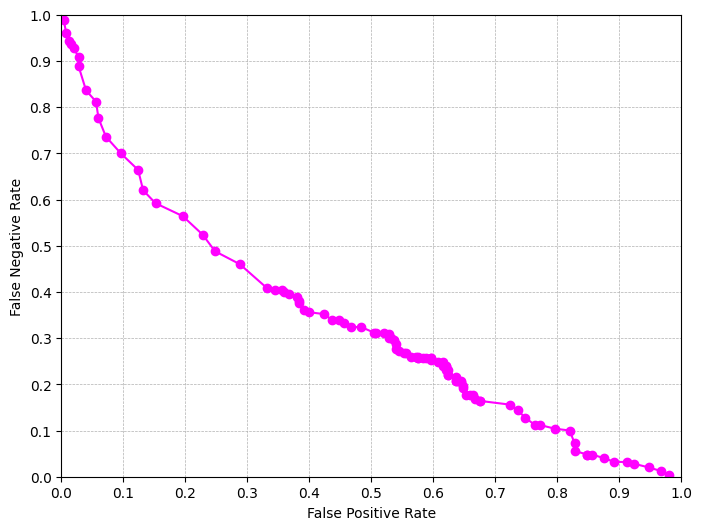

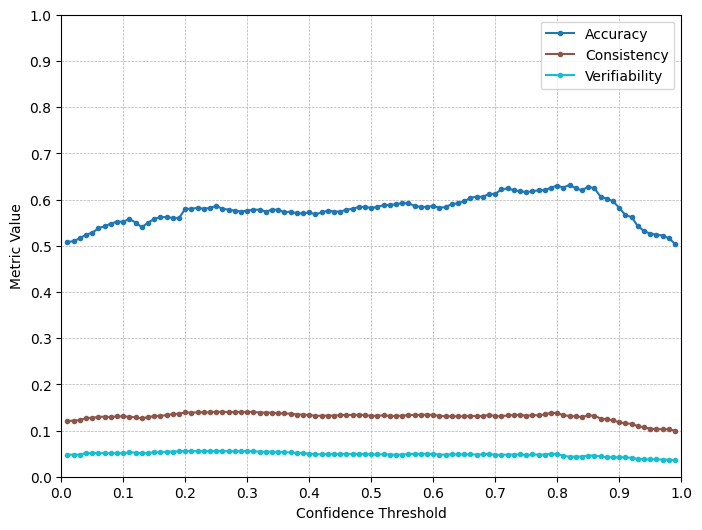

In [6]:
accuracy_metrics_by_threshold, readjusted_all_coherence_metrics, coherence_metrics, coherence_metrics_by_theshold = best_metrics

# Save accuracy and coherence metrics
json.dump(accuracy_metrics_by_threshold, 
        open(os.path.join(this_results_dir, f"tuned_metrics_accuracy_val.json"), "w"),
        indent=4)

json.dump(coherence_metrics, 
        open(os.path.join(this_results_dir, f"tuned_metrics_coherence_nli_val.json"), "w"),
        indent=4)

json.dump(readjusted_all_coherence_metrics, 
        open(os.path.join(this_results_dir, f"tuned_metrics_coherence_raw_nli_val_tuned.json"), "w"),
        indent=4)            

mi, esd, cd = best_criteria
json.dump({"max_iterations": mi, "early_stop_delta": esd, "confident_delta": cd},
          open(os.path.join(this_results_dir, "tuned_stopping_criteria.json"), "w"),
          indent=4,
)

# Generate DET curves for accuracy
generate_det_curve(accuracy_metrics_by_threshold, os.path.join(this_results_dir, f"tuned_det_accuracy_val.pdf"))

# Generate curves for all metrics by threshold
generate_tiered_metric_curves(MISTAKE_DETECTION_THRESHOLDS, 
                              [accuracy_metrics_by_threshold[t]['accuracy'] for t in MISTAKE_DETECTION_THRESHOLDS],
                              [coherence_metrics_by_threshold[t]['consistency'] for t in MISTAKE_DETECTION_THRESHOLDS], 
                              [coherence_metrics_by_threshold[t]['verifiability'] for t in MISTAKE_DETECTION_THRESHOLDS],
                              [os.path.join(this_results_dir, f"tuned_graph_tiered_metrics_nli_val.pdf")])
